## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [463]:
import sys, os, array, time
import numpy as np
import matplotlib.pyplot as plt
import IPython
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

**QUESTION:** Load dataset and display some lines of the csv file.

In [464]:
Dataset = open("ai4i2020.csv", "r").readlines()
Data_names = Dataset.pop(0).split(",")
Data_names[0] = "UDI"
Data_names[-1] = "RNF"

print(Data_names)
print(Dataset[0])
print(Dataset[99])
print(Dataset[9999])

['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0

100,L47279,L,298.8,308.8,1523,44.4,55,0,0,0,0,0,0

10000,M24859,M,299.0,308.7,1500,40.2,30,0,0,0,0,0,0



**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

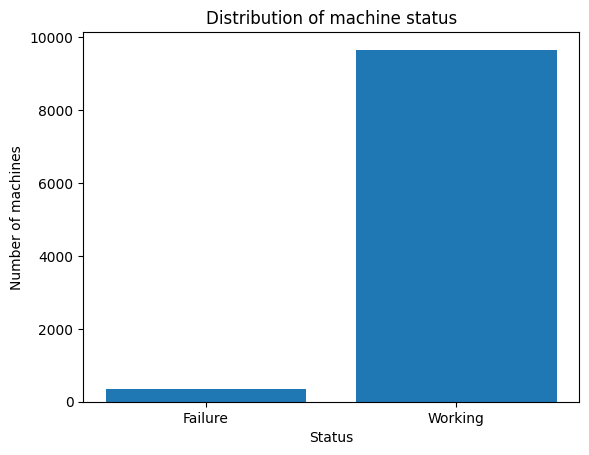

Number of failures :  339


In [465]:
usable_dataset = []
State = ["Failure", "Working"]
Number_Failure = [0,0]

for l in Dataset :
    A = l.split(",")
    B = A[-1].split("\n")
    A.pop(-1)
    A.append(B[0])
    usable_dataset.append(A)
    if (A[8] == "0") :
        Number_Failure[1] += 1
    else :
        Number_Failure[0] += 1

plt.figure(1)
plt.bar(State, Number_Failure)
plt.title('Distribution of machine status')
plt.xlabel('Status')
plt.ylabel('Number of machines')
plt.show()

print("Number of failures : ", Number_Failure[0])

**ANALYSIS QUESTION:** What do you observe?

_There are few exemples of failures in the dataset, and a lot of working machines_

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

_The model will "forget" about the failed machines and learn the parameters that implie that a machine is working_

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

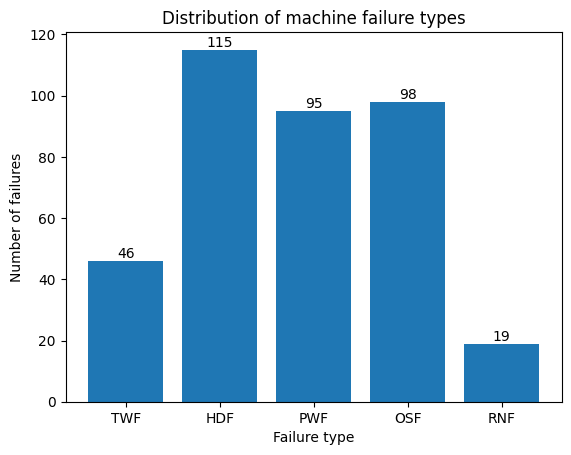

In [466]:
failure_type = ["TWF", "HDF", "PWF", "OSF", "RNF"]
failure_type_nb = [0, 0, 0, 0, 0]

for l in usable_dataset :
    if (l[9] == "1") :
        failure_type_nb[0] += 1
    if (l[10] == "1") :
        failure_type_nb[1] += 1
    if (l[11] == "1") :
        failure_type_nb[2] += 1
    if (l[12] == "1") :
        failure_type_nb[3] += 1
    if (l[13] == "1") :
        failure_type_nb[4] += 1

plt.figure(2)
plt.bar(failure_type, failure_type_nb)
plt.title('Distribution of machine failure types')
plt.xlabel('Failure type')
plt.ylabel('Number of failures')
for i, value in enumerate(failure_type_nb):
    plt.text(i, value+1, str(value), ha='center')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

_"We can see that failures are mainly due to temperature, power or overstress"_

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

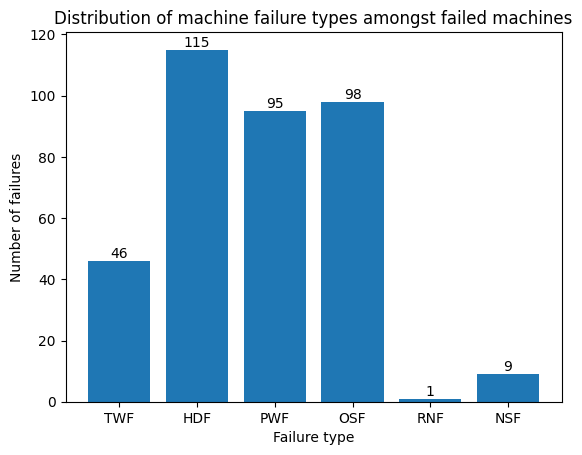

In [467]:
failure_type2 = ["TWF", "HDF", "PWF", "OSF", "RNF", "NSF"]
failure_type2_nb = [0, 0, 0, 0, 0, 0]
has_failed = 0

for l in usable_dataset :
    if (l[8] == "1") :
        has_failed = 0
        if (l[9] == "1") :
            failure_type2_nb[0] += 1
            has_failed = 1
        if (l[10] == "1") :
            failure_type2_nb[1] += 1
            has_failed = 1
        if (l[11] == "1") :
            failure_type2_nb[2] += 1
            has_failed = 1
        if (l[12] == "1") :
            failure_type2_nb[3] += 1
            has_failed = 1
        if (l[13] == "1") :
            failure_type2_nb[4] += 1
            has_failed = 1
        if (has_failed == 0) :
            failure_type2_nb[5] += 1

plt.figure(2)
plt.bar(failure_type2, failure_type2_nb)
plt.title('Distribution of machine failure types amongst failed machines')
plt.xlabel('Failure type')
plt.ylabel('Number of failures')
for i, value in enumerate(failure_type2_nb):
    plt.text(i, value+1, str(value), ha='center')
plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

_"Firstly, we observe that there are 18 random failures that did not lead to a machine failure, only 1 did lead to that.  
Secondly, there are some "Non Specific Failures", but they stay minimal compared to the specific failures."_

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [468]:
print(Data_names)

['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to use previous results to justify your response.

_"As inputs, we will use the following parameters :"_
   - Type
   - Air temperature [K]  
   - Process temperature [K]  
   - Rotational speed [rpm] 
   - Torque [Nm]  
   - Tool wear [min]  

_These are the variables that are susceptible to cause a failure, or influence in which way it can occurs as we've seen with the bar graphs that indicated use the main cause of failures._  
_"As for the outputs, we will need the following :"_ 
   - Machine working  
   - TWF
   - HDF
   - PWF
   - OSF  

_We cannot predict random failures, so we do not include it in the outputs, but we still need to know if the machine failed and what kind of failure caused it. The random failures being very sparse, and mainly not causing a machine failure, we do not need to worry about it. Additionnaly, we try to predict the fact that a machine is working in the first label, instead of looking for a failure, because if we have a specific failure, we automaticaly have a failure._  

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [469]:
X_1 = np.zeros((10000,6))
Y_1 = np.zeros((10000,5))
i=0
final_shape = 10000

for l in usable_dataset :
    if (l[2] == "M") : a = 0
    elif (l[2] == "L") : a = 1
    else : a = 2
    if (float(l[9]) + float(l[10]) + float(l[11]) + float(l[12]) <= 1) :
        X_1[i][0] = a
        X_1[i][1] = float(l[3])
        X_1[i][2] = float(l[4])
        X_1[i][3] = float(l[5])
        X_1[i][4] = float(l[6])
        X_1[i][5] = float(l[7])
        B = [abs(1.0-float(l[8])), float(l[9]) ,float(l[10]) ,float(l[11]), float(l[12])]
        Y_1[i] = B
        i+=1
    else : final_shape -= 1

X = np.zeros((final_shape,6))
Y = np.zeros((final_shape,5))
X = X_1[0:final_shape]
Y = Y_1[0:final_shape]
X_train, X_temporary, Y_train, Y_temporary = train_test_split(X, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_temporary, Y_temporary, test_size=0.5)

print("Shape of the training dataset. X : ", np.shape(X_train), " , Y : ", np.shape(Y_train))
print("Shape of the validation dataset. X : ", np.shape(X_val), " , Y : ", np.shape(Y_val))
print("Shape of the test dataset. X : ", np.shape(X_test), " , Y : ", np.shape(Y_test))

Shape of the training dataset. X :  (6983, 6)  , Y :  (6983, 5)
Shape of the validation dataset. X :  (1497, 6)  , Y :  (1497, 5)
Shape of the test dataset. X :  (1497, 6)  , Y :  (1497, 5)


**QUESTION** Code below the model architecture

In [470]:
def display_training_curves(training_history):
  # display loss
  plt.plot(training_history.history['loss'],label='loss')
  plt.plot(training_history.history['val_loss'], label='val_loss')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()
  #display accuracy
  plt.plot(training_history.history['accuracy'],label='acc')
  plt.plot(training_history.history['val_accuracy'], label='val_acc')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(6) #my input layer
x = tf.keras.layers.Dense(20, activation='tanh')(inputs) #a first hidden layer with 20 neurons
x = tf.keras.layers.Dense(10, activation='tanh')(x) #a first hidden layer with 20 neurons
x = tf.keras.layers.Dense(10, activation='tanh')(x) #a first hidden layer with 20 neurons
outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # my output layer, with 4 neurons (instead of the 10 originaly stated), for the 4 classes
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "my_mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_67 (InputLayer)       [(None, 6)]               0         
                                                                 
 dense_464 (Dense)           (None, 20)                140       
                                                                 
 dense_465 (Dense)           (None, 10)                210       
                                                                 
 dense_466 (Dense)           (None, 10)                110       
                                                                 
 dense_467 (Dense)           (None, 5)                 55        
                                                                 
Total params: 515 (2.01 KB)
Trainable params: 515 (2.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/20
70/70 [==============================] - 1s 4ms/step - loss: 0.7278 - accuracy: 0.7531 - val_loss: 0.2395 - val_accuracy: 0.9739
Epoch 2/20
70/70 [==============================] - 0s 2ms/step - loss: 0.2122 - accuracy: 0.9686 - val_loss: 0.1729 - val_accuracy: 0.9739
Epoch 3/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1864 - accuracy: 0.9686 - val_loss: 0.1614 - val_accuracy: 0.9739
Epoch 4/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1802 - accuracy: 0.9686 - val_loss: 0.1583 - val_accuracy: 0.9739
Epoch 5/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1777 - accuracy: 0.9686 - val_loss: 0.1544 - val_accuracy: 0.9739
Epoch 6/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1742 - accuracy: 0.9686 - val_loss: 0.1533 - val_accuracy: 0.9739
Epoch 7/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1708 - accuracy: 0.9686 - val_loss: 0.1524 - val_accuracy: 0.9739
Epoch 8/20
70/70 [==

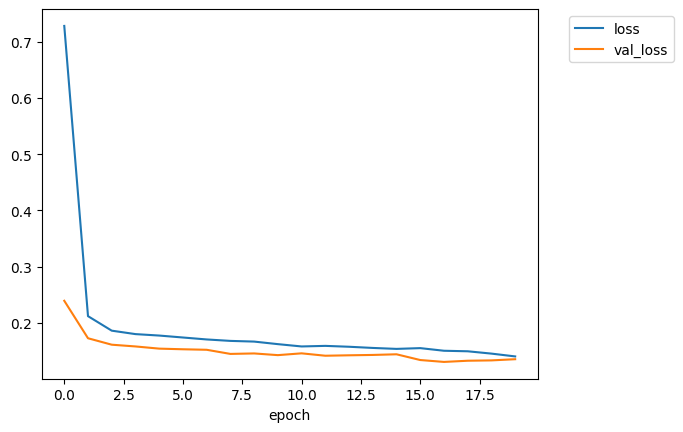

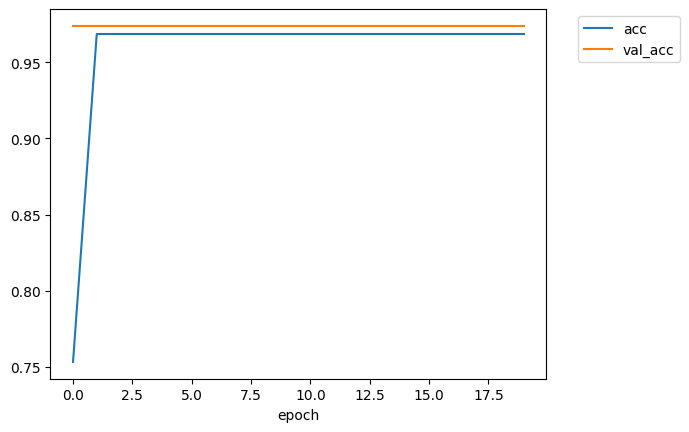

In [471]:
# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=20
batch_size=100
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

display_training_curves(training_history)

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





47/47 [==============================] - 0s 875us/step
Classification report for classifier my_cnn_model:
              precision    recall  f1-score   support

  No Failure       0.97      1.00      0.98      1448
         TWF       0.00      0.00      0.00         3
         HDF       0.00      0.00      0.00        18
         PWF       0.00      0.00      0.00        12
         OSF       0.00      0.00      0.00        16

   micro avg       0.97      0.97      0.97      1497
   macro avg       0.19      0.20      0.20      1497
weighted avg       0.94      0.97      0.95      1497
 samples avg       0.97      0.97      0.97      1497




C:\Users\kevin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


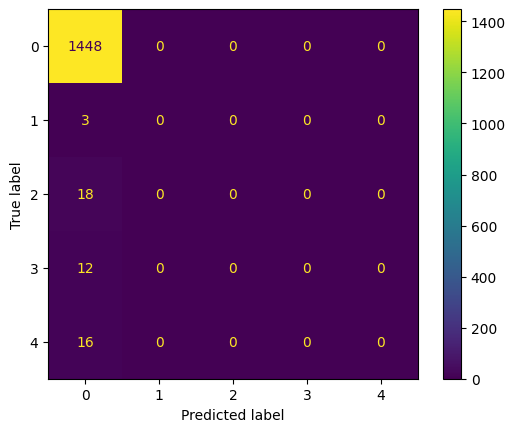

In [472]:
Y_pred_temp = my_mlp_model.predict(X_test)

Y_pred = np.zeros_like(Y_pred_temp)
Y_pred[np.arange(Y_pred_temp.shape[0]), np.argmax(Y_pred_temp, axis=1)] = 1


Y_test_bin  = np.zeros_like(Y_test)
Y_test_bin[np.arange(len(Y_test)), np.argmax(Y_test, axis=1)] = 1

class_names = ["No Failure", "TWF", "HDF", "PWF", "OSF"]

print(
    f"Classification report for classifier my_cnn_model:\n"
    f"{classification_report(Y_test_bin, Y_pred, target_names=class_names)}\n"
)

cm = confusion_matrix(Y_test_bin.argmax(axis=1), Y_pred.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

_Our model isn't able to learn the causes of errors, he correctly predicts when a machine is working, but as soon as there is a failure, he predicts that the machine is working. This is because there are mainly working machines in the dataset, and so he only learns what makes that a machine works._  
_So, we need to modify slightly our dataset for the model to learn correctly._

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [473]:
Y_label = np.array([np.argmax(row) for row in Y])
print('Original dataset shape %s' % Counter(Y_label))

## Under sampling of the dataset to reduce the number of machine in working conditions
rus = RandomUnderSampler(random_state=42, sampling_strategy={0:1500, 1:43, 2:106, 3:80, 4:78})
X_res, Y_res = rus.fit_resample(X, Y_label)
print('Resampled dataset shape %s' % Counter(Y_res))

## Over sampling of the dataset to augment the number of machine in failure state
sm = SMOTE(random_state=42, sampling_strategy={0:7000, 1:6500, 2:6500, 3:6500, 4:6500})
X_balanced, Y_balanced = sm.fit_resample(X_res, Y_res)
print('Resampled dataset shape %s' % Counter(Y_balanced))

# Convertir les étiquettes rééchantillonnées en format multilabel (one-hot encoding)
Y_balanced_multilabel = np.zeros((Y_balanced.size, Y.shape[1]))
Y_balanced_multilabel[np.arange(Y_balanced.size), Y_balanced] = 1

## Creation of the training and testing sets
X_train, X_temporary, Y_train, Y_temporary = train_test_split(X_balanced, Y_balanced_multilabel, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_temporary, Y_temporary, test_size=0.5)

print("Shape of the training dataset. X : ", np.shape(X_train), " , Y : ", np.shape(Y_train))
print("Shape of the validation dataset. X : ", np.shape(X_val), " , Y : ", np.shape(Y_val))
print("Shape of the test dataset. X : ", np.shape(X_test), " , Y : ", np.shape(Y_test))

Original dataset shape Counter({0: 9670, 2: 106, 3: 80, 4: 78, 1: 43})
Resampled dataset shape Counter({0: 1500, 2: 106, 3: 80, 4: 78, 1: 43})
Resampled dataset shape Counter({0: 7000, 1: 6500, 2: 6500, 3: 6500, 4: 6500})
Shape of the training dataset. X :  (23100, 6)  , Y :  (23100, 5)
Shape of the validation dataset. X :  (4950, 6)  , Y :  (4950, 5)
Shape of the test dataset. X :  (4950, 6)  , Y :  (4950, 5)


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [474]:
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(6) #my input layer
x = tf.keras.layers.Dense(48, activation='relu', kernel_regularizer=l2(0.0005))(inputs) #a first hidden layer with 20 neurons
x = tf.keras.layers.Dropout(0.2)(x)  # 20% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

x = tf.keras.layers.Dense(96, activation='relu', kernel_regularizer=l2(0.0005))(x) #a first hidden layer with 20 neurons
x = tf.keras.layers.Dropout(0.3)(x)  # 20% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

x = tf.keras.layers.Dense(192, activation='relu', kernel_regularizer=l2(0.0005))(x) #a first hidden layer with 20 neurons
x = tf.keras.layers.Dropout(0.3)(x)  # 20% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x) #a first hidden layer with 20 neurons
x = tf.keras.layers.Dropout(0.35)(x)  # 20% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x) #a first hidden layer with 20 neurons
x = tf.keras.layers.Dropout(0.35)(x)  # 20% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

x = tf.keras.layers.Dense(192, activation='relu', kernel_regularizer=l2(0.0005))(x) #a first hidden layer with 20 neurons
x = tf.keras.layers.Dropout(0.3)(x)  # 20% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.0005))(x) #a first hidden layer with 20 neurons
x = tf.keras.layers.Dropout(0.3)(x)  # 20% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

x = tf.keras.layers.Dense(96, activation='relu', kernel_regularizer=l2(0.0005))(x) #a first hidden layer with 20 neurons
x = tf.keras.layers.Dropout(0.3)(x)  # 20% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

x = tf.keras.layers.Dense(48, activation='relu', kernel_regularizer=l2(0.0005))(x) #a first hidden layer with 20 neurons
x = tf.keras.layers.Dropout(0.2)(x)  # 20% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # my output layer, with 4 neurons (instead of the 10 originaly stated), for the 4 classes
#Then, I define my model with the input layer, the output layer and a name
my_mpl2_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mpl2_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mpl2_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mpl2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "my_mpl2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_68 (InputLayer)       [(None, 6)]               0         
                                                                 
 dense_468 (Dense)           (None, 48)                336       
                                                                 
 dropout_218 (Dropout)       (None, 48)                0         
                                                                 
 batch_normalization_236 (B  (None, 48)                192       
 atchNormalization)                                              
                                                                 
 dense_469 (Dense)           (None, 96)                4704      
                                                                 
 dropout_219 (Dropout)       (None, 96)                0         
                                                     

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/40
231/231 [==============================] - 5s 8ms/step - loss: 2.2630 - accuracy: 0.2858 - val_loss: 1.9660 - val_accuracy: 0.3943
Epoch 2/40
231/231 [==============================] - 2s 7ms/step - loss: 1.7072 - accuracy: 0.5025 - val_loss: 1.6627 - val_accuracy: 0.4347
Epoch 3/40
231/231 [==============================] - 1s 6ms/step - loss: 1.4240 - accuracy: 0.6515 - val_loss: 1.4212 - val_accuracy: 0.6057
Epoch 4/40
231/231 [==============================] - 1s 6ms/step - loss: 1.2426 - accuracy: 0.7197 - val_loss: 1.1974 - val_accuracy: 0.6941
Epoch 5/40
231/231 [==============================] - 1s 6ms/step - loss: 1.1326 - accuracy: 0.7532 - val_loss: 0.9671 - val_accuracy: 0.7875
Epoch 6/40
231/231 [==============================] - 1s 6ms/step - loss: 1.0582 - accuracy: 0.7705 - val_loss: 0.9881 - val_accuracy: 0.7509
Epoch 7/40
231/231 [==============================] - 1s 6ms/step - loss: 0.9917 - accuracy: 0.7792 - val_loss: 0.8386 - val_accuracy: 0.8137
Epoch 

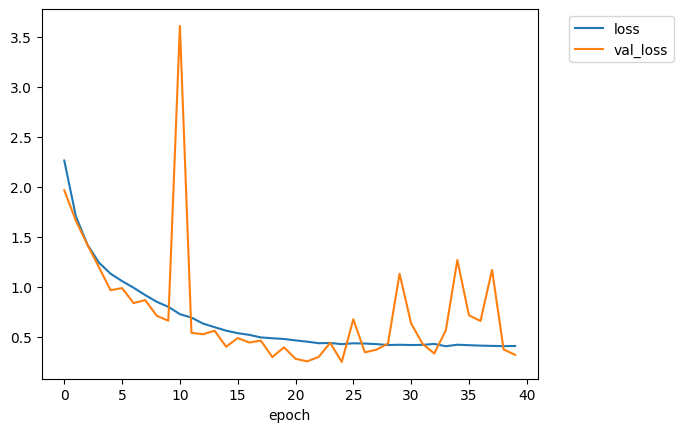

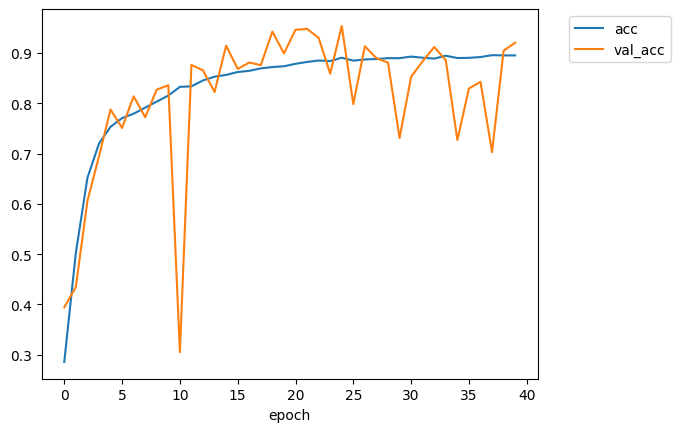

In [475]:
# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=40
batch_size=100
training_history = my_mpl2_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mpl2_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mpl2_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

display_training_curves(training_history)

**QUESTION** Plot the confusion matrix and the classification report

155/155 [==============================] - 1s 2ms/step
Classification report for classifier my_mpl2_model:
              precision    recall  f1-score   support

  No Failure       1.00      0.78      0.88      1050
         TWF       0.91      0.90      0.91       953
         HDF       0.88      0.94      0.91       981
         PWF       0.98      1.00      0.99      1001
         OSF       0.87      1.00      0.93       965

   micro avg       0.92      0.92      0.92      4950
   macro avg       0.93      0.92      0.92      4950
weighted avg       0.93      0.92      0.92      4950
 samples avg       0.92      0.92      0.92      4950




C:\Users\kevin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


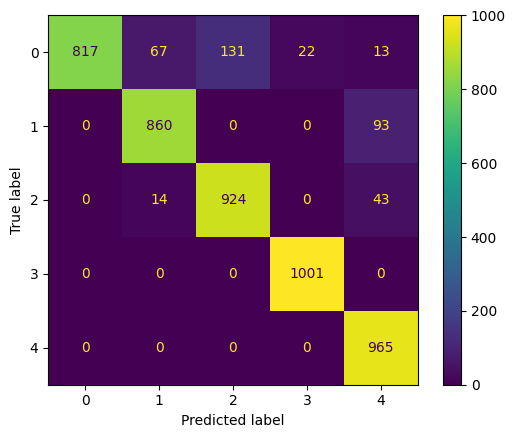

In [476]:
Y_pred_temp = my_mpl2_model.predict(X_test)

Y_pred = np.zeros_like(Y_pred_temp)
Y_pred[np.arange(Y_pred_temp.shape[0]), np.argmax(Y_pred_temp, axis=1)] = 1


Y_test_bin  = np.zeros_like(Y_test)
Y_test_bin[np.arange(len(Y_test)), np.argmax(Y_test, axis=1)] = 1

print(
    f"Classification report for classifier my_mpl2_model:\n"
    f"{classification_report(Y_test_bin, Y_pred, target_names=class_names)}\n"
)

cm = confusion_matrix(Y_test_bin.argmax(axis=1), Y_pred.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()

## Saving some data to test on the STM32
np.save("Machine_Failure_X_test.npy", X_test[:525])
np.save("Machine_Failure_Y_test.npy", Y_test[:525])
## Saving the model
my_mpl2_model.save("Machine_Failure_model.h5")

**ANALYSIS QUESTION** What do you observe? What can you conclude?

_The learning is quite random, but, when he start correctly, it has a really good learning capability. It is almost a 50/50 chance to get a really good model, or a quite binary and innacurate one._  
_The problem is in the dataset which is quite random due to the nature of the upsampled datas, when it has a good set, it is much more likely to get a good model._